
# Identifying Sleep Times

## Notebook Goal: 
* Create visualization pipelines for each patient to identify sleep times.
* Create a function to identify sleep times for each patient.


In [1]:
%load_ext autoreload
%autoreload 2

## Data Load

In [79]:
from src.data.data_loader import load_data
from src.data.data_cleaner import clean_data
import pandas as pd

# Load the data with specified columns
df = load_data(data_source_name="kaggle_brisT1D", dataset_type="train")

ModuleNotFoundError: No module named 'sktime.transformations.series.sliding_window'

In [3]:
def keep_time_zero_columns(
    df, additional_cols: list = ["id", "p_num", "time", "bg+1:00"]
):
    """
    Provide a list of columns to keep that contain '-0:00' in their names

    Args:
        df (pd.DataFrame): Input DataFrame
        additional_cols (list): List of columns to keep in addition to the ones with '-0:00' in their names

    Returns:
        list: list of column names
    """
    time_zero_cols = [col for col in df.columns if "-0:00" in col]
    additional_cols += time_zero_cols
    print(f"Keeping {additional_cols} columns")
    return additional_cols


keep_columns_train = keep_time_zero_columns(df)
keep_columns_test = keep_columns_train.copy()
keep_columns_test.remove("bg+1:00")
print("train columns: ", keep_columns_train)
print("test columns: ", keep_columns_test)

Keeping ['id', 'p_num', 'time', 'bg+1:00', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00'] columns
train columns:  ['id', 'p_num', 'time', 'bg+1:00', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00']
test columns:  ['id', 'p_num', 'time', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00']


In [4]:
train_df = load_data(
    data_source_name="kaggle_brisT1D",
    dataset_type="train",
    keep_columns=keep_columns_train,
)

In [90]:
sample_df = train_df[train_df["p_num"] == "p01"]
# sample_df['time'] = pd.to_datetime(sample_df['time'])
sample_df.shape


(8459, 11)

C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\804045518.py:91: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sample_df['time'] = pd.to_datetime(sample_df['time'])
C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\804045518.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['time'] = pd.to_datetime(sample_df['time'])
C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\804045518.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

<Figure size 1200x600 with 0 Axes>

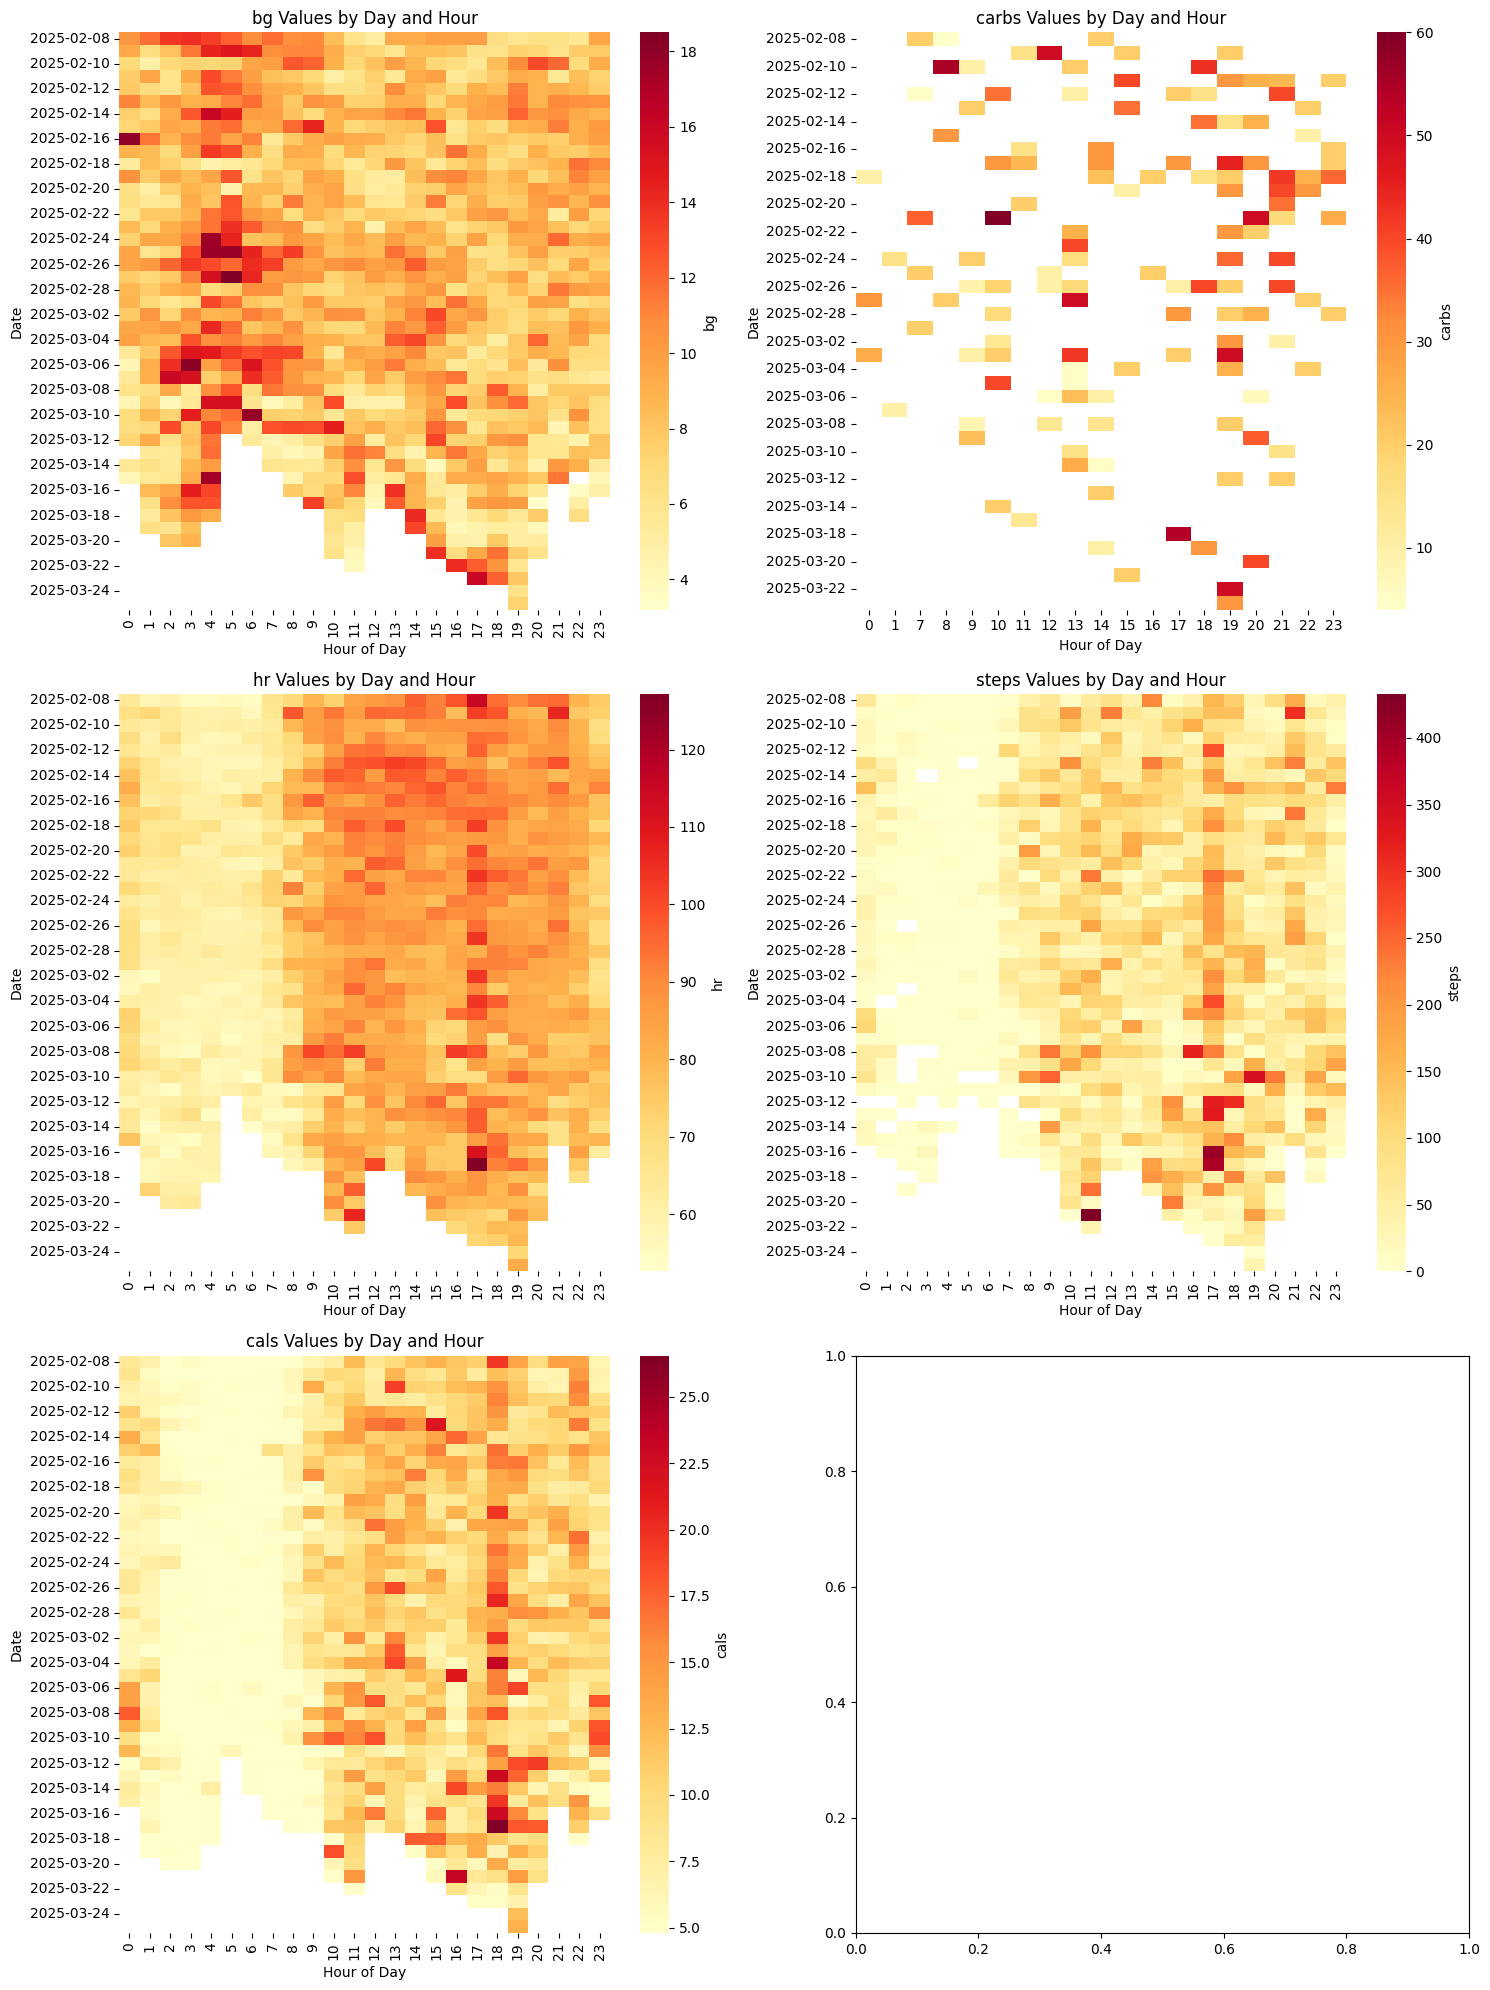

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hourly_averages(df, features, ax):
    """
    Plots average values by hour for each feature on the given axis.
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'hour' column and feature columns
        features (list): List of feature column names to plot
        ax (matplotlib.axes.Axes): Matplotlib axis to plot on
        
    Returns:
        None - plots directly on provided axis
    """
    hourly_means = df.groupby('hour')[features].agg(lambda x: x.mean(skipna=True))
    for col in features:
        if hourly_means[col].notna().any():
            hourly_means[col].plot(kind='line', marker='o', ax=ax, label=col.split("-")[0])
    ax.set_title('Average Values by Hour')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Value')
    ax.grid(True)
    ax.legend()

def plot_daily_heatmaps(df, features):
    """
    Creates heatmaps showing feature values across days and hours.
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'date', 'hour' columns and feature columns
        features (list): List of feature column names to plot
        
    Returns:
        matplotlib.figure.Figure: Figure containing the heatmap subplots
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    for idx, col in enumerate(features):
        pivot_data = df.pivot_table(
            values=col,
            index='date',
            columns='hour',
            aggfunc='mean'
        )
        
        sns.heatmap(
            pivot_data,
            cmap='YlOrRd',
            ax=axes[idx],
            cbar_kws={'label': col.split("-")[0]}
        )
        axes[idx].set_title(f'{col.split("-")[0]} Values by Day and Hour')
        axes[idx].set_xlabel('Hour of Day')
        axes[idx].set_ylabel('Date')

    plt.tight_layout()
    return fig

def plot_feature_distributions(df, features):
    """
    Creates box plots showing distribution of feature values by hour.
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'hour' column and feature columns
        features (list): List of feature column names to plot
        
    Returns:
        matplotlib.figure.Figure: Figure containing the boxplot subplots
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    for idx, col in enumerate(features):
        sns.boxplot(
            data=df,
            x='hour',
            y=col,
            ax=axes[idx]
        )
        axes[idx].set_title(f'{col.split("-")[0]} Distribution by Hour')
        axes[idx].set_xlabel('Hour of Day')
        axes[idx].set_ylabel('Value')
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

# convert time to datetime and handle duplicate entries by assigning sequential days
sample_df['time'] = pd.to_datetime(sample_df['time'])
# for each duplicate time, increment the date by the duplicate count
sample_df['day_offset'] = sample_df.groupby('time').cumcount()
sample_df['time'] = sample_df.apply(lambda x: x['time'] + pd.Timedelta(days=x['day_offset']), axis=1)
# extract hour and date after handling duplicates
sample_df['hour'] = sample_df['time'].dt.hour
sample_df['date'] = sample_df['time'].dt.date
# drop the temporary offset column
sample_df.drop('day_offset', axis=1, inplace=True)

feature_cols = ['bg-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00']

# create figures
plt.figure(figsize=(12, 6))
# plot_hourly_averages(sample_df, feature_cols, plt.gca())
# plt.show()

plot_daily_heatmaps(sample_df, feature_cols)
plt.show()

# plot_feature_distributions(sample_df, feature_cols)
# plt.show()


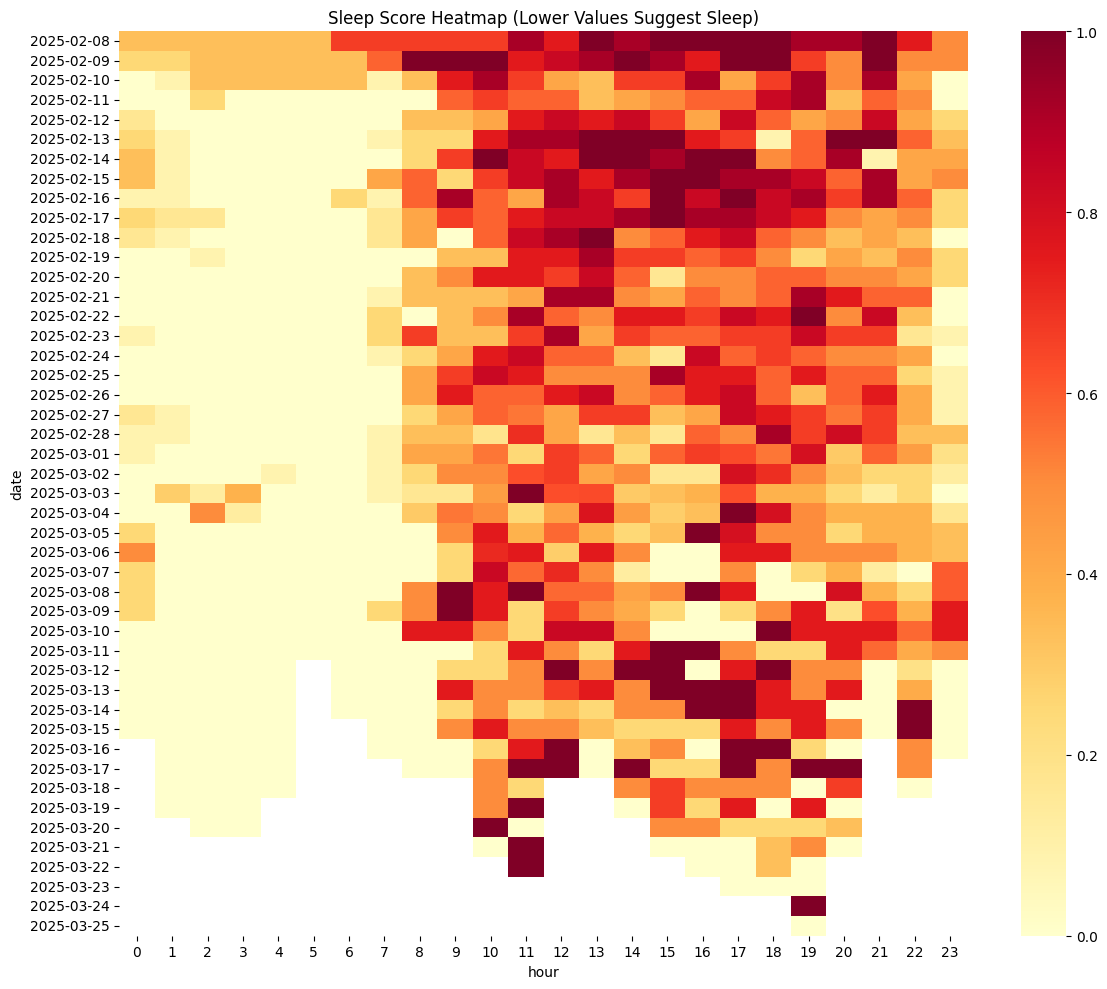

In [97]:
def determine_sleep_score(df, relevant_features: list = ['hr-0:00', 'steps-0:00', 'cals-0:00', 'carbs-0:00']):
    """
    Determine sleep times for each patient based on the data by analyzing feature correlations.
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'time' column and feature columns
        relevant_features (list): List of features to use for sleep detection
        
    Returns:
        pd.DataFrame: DataFrame with sleep predictions and visualization
    """
    # filter out features with all None values
    valid_features = [f for f in relevant_features if not df[f].isna().all()]
    
    # normalize each feature between 0 and 1
    normalized_data = pd.DataFrame()
    for feature in valid_features:
        # Handle NaN values with interpolation first, then fill remaining with mean
        feature_data = df[feature].interpolate(method='linear', limit_direction='both')
        feature_data = feature_data.fillna(feature_data.mean())  # Fill any remaining NaNs
        if feature_data.max() != feature_data.min():  # Prevent division by zero
            normalized_data[feature] = (feature_data - feature_data.min()) / (feature_data.max() - feature_data.min())
        else:
            normalized_data[feature] = 0  # Set constant features to 0
    
    # Calculate sleep score based on low activity levels
    sleep_score = pd.Series(0.0, index=df.index)
    
    # Puts more weight on heart rate than steps or cals! this can be dynamic as well if some
    # feature have more nan values than others
    weights = {
        'hr-0:00': 0.7,
        'steps-0:00': 0.2, 
        'cals-0:00': 0.1,
        'carbs-0:00': 0.0
    }
    
    for feature in valid_features:
        if feature in weights:
            # SOP 
            sleep_score += (normalized_data[feature]) * weights[feature]
    
    # Apply rolling mean to smooth out scattered predictions
    sleep_score = sleep_score.rolling(window=3, min_periods=1, center=True).mean()
    
    # place threshold so that there are more distinc 8 hour blocks
    quantile = 0.6 # the higher, the more number of blocks are predicted as sleep
    sleep_threshold = sleep_score.quantile(quantile)  # Adjust threshold as needed
    sleep_score = (sleep_score > sleep_threshold).astype(float)
    
    # Create visualization
    fig, ax2 = plt.subplots(figsize=(12, 10))
    # Plot normalized features
    # normalized_data.plot(ax=ax1)
    # ax1.set_title('Normalized Feature Values')
    # ax1.set_xlabel('Time')
    # ax1.set_ylabel('Normalized Value')
    
    # Plot sleep score heatmap
    sleep_df = pd.DataFrame({
        'hour': df['hour'],
        'date': df['date'],
        'sleep_score': sleep_score
    })
    pivot_sleep = pd.pivot_table(
        sleep_df,
        values='sleep_score',
        index='date',
        columns='hour',
        aggfunc='mean'
    )
    sns.heatmap(pivot_sleep, ax=ax2, cmap='YlOrRd')
    ax2.set_title('Sleep Score Heatmap (Lower Values Suggest Sleep)')
    
    plt.tight_layout()
    plt.show()
    
    return sleep_df

sleep_predictions = determine_sleep_score(sample_df)



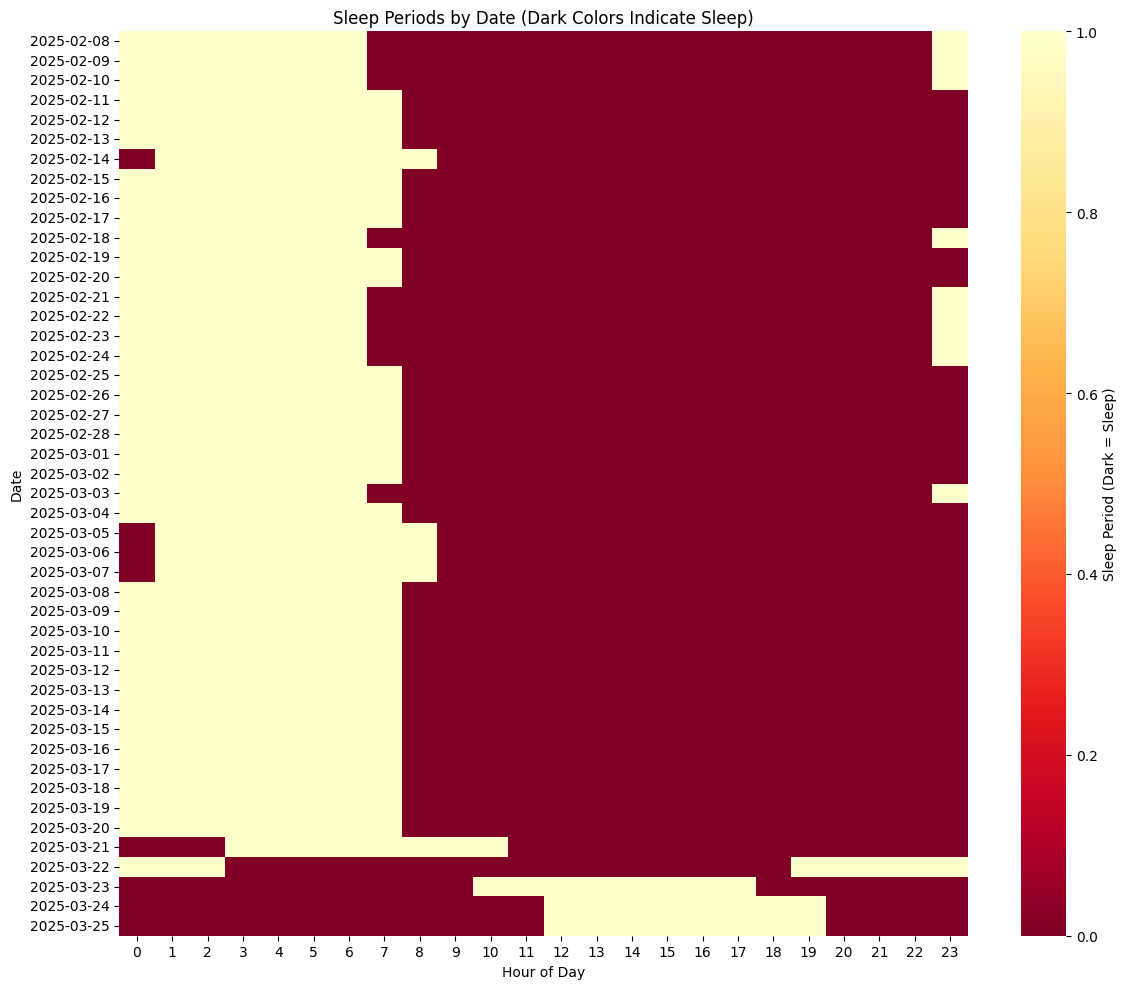

,date,sleep_start,sleep_end,sleep_duration
0,2025-02-08,23,7,8
1,2025-02-09,23,7,8
2,2025-02-10,23,7,8
3,2025-02-11,0,8,8
4,2025-02-12,0,8,8
5,2025-02-13,0,8,8
6,2025-02-14,1,9,8
7,2025-02-15,0,8,8
8,2025-02-16,0,8,8
9,2025-02-17,0,8,8


In [98]:
def determine_sleep_hours(sleep_df: pd.DataFrame):
    """
    Determine sleep hours for each patient and visualize as a heatmap showing sleep periods.
    Finds the 8-hour window with lowest average sleep score per day.
    NOTE: Dark colors indicate predicted sleep periods in the heatmap
    NOTE: This is assuming the person sleeps for 8 hours straight; so all predictions are 8 hour windows
    NOTE: NaN values can really mess up the predictions (eg: for P01 in the kaggle data, the last few days have many NaNs, 
    so the sleep time predictions are between 11:00 AM and 7:00 PM, which is absurd)- see the heatmap below
    
    Args:
        sleep_df (pd.DataFrame): DataFrame containing sleep score data with 'hour' and 'date' columns

        Can be generated via determine_sleep_score function above
    Returns:
        pd.DataFrame: DataFrame with predicted sleep start and end times for each date
    """
    
    # Group by date to analyze each day separately
    results = []
    for date, day_data in sleep_df.groupby('date'):
        # Sort by hour to ensure correct window order
        day_data = day_data.sort_values('hour')
        
        # Find 8-hour window with lowest average sleep score
        min_avg_score = float('inf')
        best_start = 0
        best_end = 8
        
        for start_hour in range(24):
            # Calculate end hour wrapping around midnight if needed
            end_hour = (start_hour + 8) % 24
            
            # get sleep scores data from the window
            if end_hour > start_hour:
                window_data = day_data[
                    (day_data['hour'] >= start_hour) & 
                    (day_data['hour'] < end_hour)
                ]
            else:
                # Handle overnight windows
                window_data = day_data[
                    (day_data['hour'] >= start_hour) | 
                    (day_data['hour'] < end_hour)
                ]
            
            avg_score = window_data['sleep_score'].mean()
            if avg_score < min_avg_score:
                min_avg_score = avg_score
                best_start = start_hour
                best_end = end_hour
                
        results.append({
            'date': date,
            'sleep_start': best_start,
            'sleep_end': best_end,
            'sleep_duration': 8
        })
    
    results_df = pd.DataFrame(results)
    
    # heatmap matrix!
    hours = range(24)
    sleep_matrix = pd.DataFrame(0, index=results_df['date'], columns=hours)
    
    # fill in sleep periods with 1s (for the purpose of putting it on a heatmap)
    for _, row in results_df.iterrows():
        start = int(row['sleep_start'])
        end = int(row['sleep_end'])
        if end < start:  # if, for example, the user slept at 1:00 am and woke at 8:00 am
            end += 24
        for hour in range(start, end):
            hour = hour % 24  # Wrap hours back to 0-23 range
            sleep_matrix.loc[row['date'], hour] = 1
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(sleep_matrix, cmap='YlOrRd_r', cbar_kws={'label': 'Sleep Period (Dark = Sleep)'})
    plt.title('Sleep Periods by Date (Dark Colors Indicate Sleep)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()

    return results_df

determine_sleep_hours(sleep_predictions)

In [32]:
# TODO: Untested (Dose not work since kaggle data does not provide exact days when the data was collected). ALso this is ai generated code.
def plot_weekend_vs_weekday_heatmaps(df, features):
    """
    Create heatmaps comparing weekday vs weekend patterns
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'time' column and feature columns
        features (list): List of feature column names to plot
        
    Returns:
        matplotlib.figure.Figure: Figure containing the heatmap subplots
    """
    # Add weekend flag
    df['is_weekend'] = df['time'].dt.dayofweek.isin([4, 5, 6])  # Fri, Sat, Sun
    
    fig, axes = plt.subplots(len(features), 2, figsize=(15, 5*len(features)))
    
    for idx, col in enumerate(features):
        # Weekday data
        weekday_data = df[~df['is_weekend']].copy()
        pivot_weekday = pd.pivot_table(
            weekday_data,
            values=col,
            index='date',
            columns='hour',
            aggfunc='mean',
            fill_value=0  # Fill NaN values with 0 to avoid fmin error
        )
        
        # Weekend data  
        weekend_data = df[df['is_weekend']].copy()
        pivot_weekend = pd.pivot_table(
            weekend_data,
            values=col,
            index='date', 
            columns='hour',
            aggfunc='mean',
            fill_value=0  # Fill NaN values with 0 to avoid fmin error
        )
        
        # Check if pivot tables are empty
        if pivot_weekday.empty or pivot_weekend.empty:
            print(f"Warning: No data available for {col}")
            continue
            
        # Plot weekday heatmap
        sns.heatmap(
            pivot_weekday,
            cmap='YlOrRd',
            ax=axes[idx],
            cbar_kws={'label': col.split("-")[0]},
            robust=True  # Use robust scaling to handle outliers
        )
        axes[idx,0].set_title(f'{col.split("-")[0]} Values - Weekdays')
        axes[idx,0].set_xlabel('Hour of Day')
        axes[idx,0].set_ylabel('Date')
        
        # Plot weekend heatmap
        sns.heatmap(
            pivot_weekend, 
            cmap='YlOrRd',
            ax=axes[idx,1],
            cbar_kws={'label': col.split("-")[0]},
            robust=True  # Use robust scaling to handle outliers
        )
        axes[idx,1].set_title(f'{col.split("-")[0]} Values - Weekends')
        axes[idx,1].set_xlabel('Hour of Day')
        axes[idx,1].set_ylabel('Date')

    plt.tight_layout()
    return fig

# Create weekend vs weekday comparison
plot_weekend_vs_weekday_heatmaps(sample_df, feature_cols)
plt.show()


No features have both weekday and weekend data


C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\1516101116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekend'] = df['time'].dt.dayofweek.isin([4, 5, 6])  # Fri, Sat, Sun
